In [42]:
import pandas as pd

import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [44]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("avhikj/churn-predictions-personal")

print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "Churn_Predictions.csv"))
df.drop(['CustomerId', 'Surname', 'Geography'], axis=1, inplace=True)
df.NumOfProducts = df['NumOfProducts'].astype('object')

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
feats = df.drop('Exited', axis=1)
target = df['Exited']

feats = pd.get_dummies(feats, prefix=['products'], prefix_sep='_')
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25)

cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

sc = StandardScaler()
X_train[cols] = sc.fit_transform(X_train[cols])
X_test[cols] = sc.transform(X_test[cols])

print(target.value_counts(normalize=True))



Path to dataset files: /Users/notagain/.cache/kagglehub/datasets/avhikj/churn-predictions-personal/versions/1
0    0.7963
1    0.2037
Name: Exited, dtype: float64


/var/folders/xh/2_ykktld4lz_4rb5ny5cphk40000gn/T/ipykernel_41346/3715720557.py:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  feats = pd.get_dummies(feats, prefix=['products'], prefix_sep='_')


In [45]:
svm = SVC(gamma='scale')
svm.fit(X_train, y_train)

print('Score sur ensemble test', svm.score(X_test, y_test))

Score sur ensemble test 0.7928


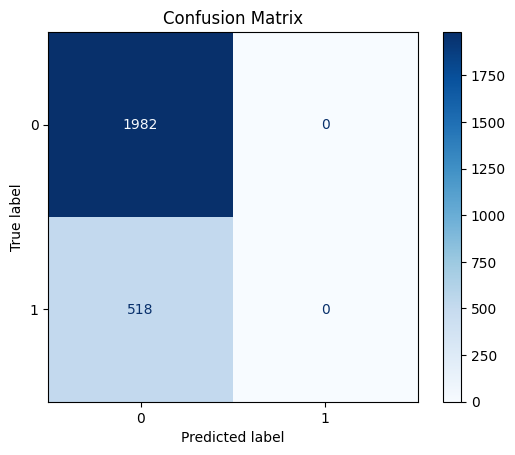

In [46]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'svm' is your trained SVM model and 'X_test', 'y_test' are the test data
y_pred = svm.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



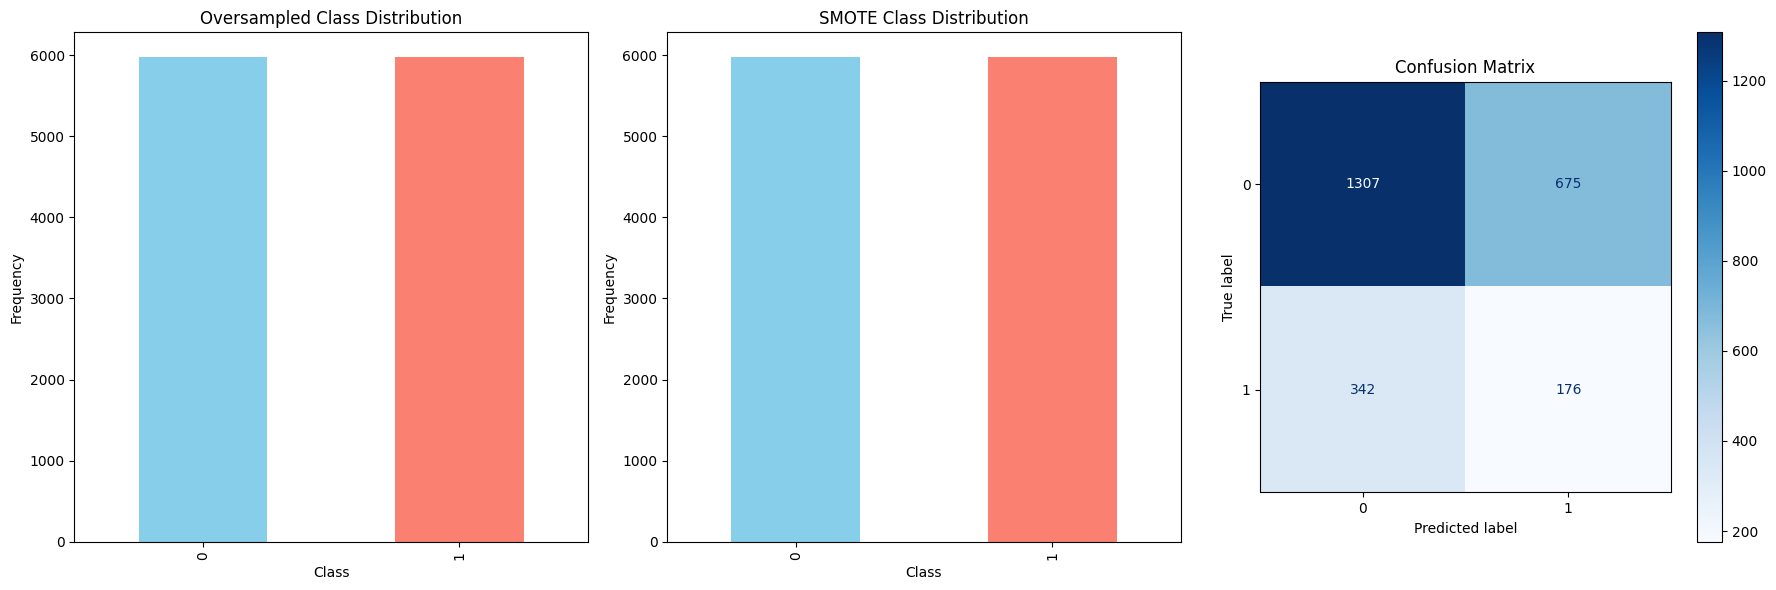

In [57]:
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)

# SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)

svm = SVC(gamma='scale')
svm.fit(X_ro, y_ro)

y_pred = svm.predict(X_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot oversampled class distribution
pd.Series(y_ro).value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title('Oversampled Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')

# Plot SMOTE class distribution
pd.Series(y_sm).value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('SMOTE Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svm.classes_).plot(cmap=plt.cm.Blues, ax=axes[2])
axes[2].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [60]:
# Ensure that the data types are compatible for resampling
X_train = X_train.astype(np.float32)

# Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

# Centroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)
print('Classes échantillon CC :', dict(pd.Series(y_cc).value_counts()))

Classes échantillon undersampled : {0: 1519, 1: 1519}
Classes échantillon CC : {0: 1519, 1: 1519}


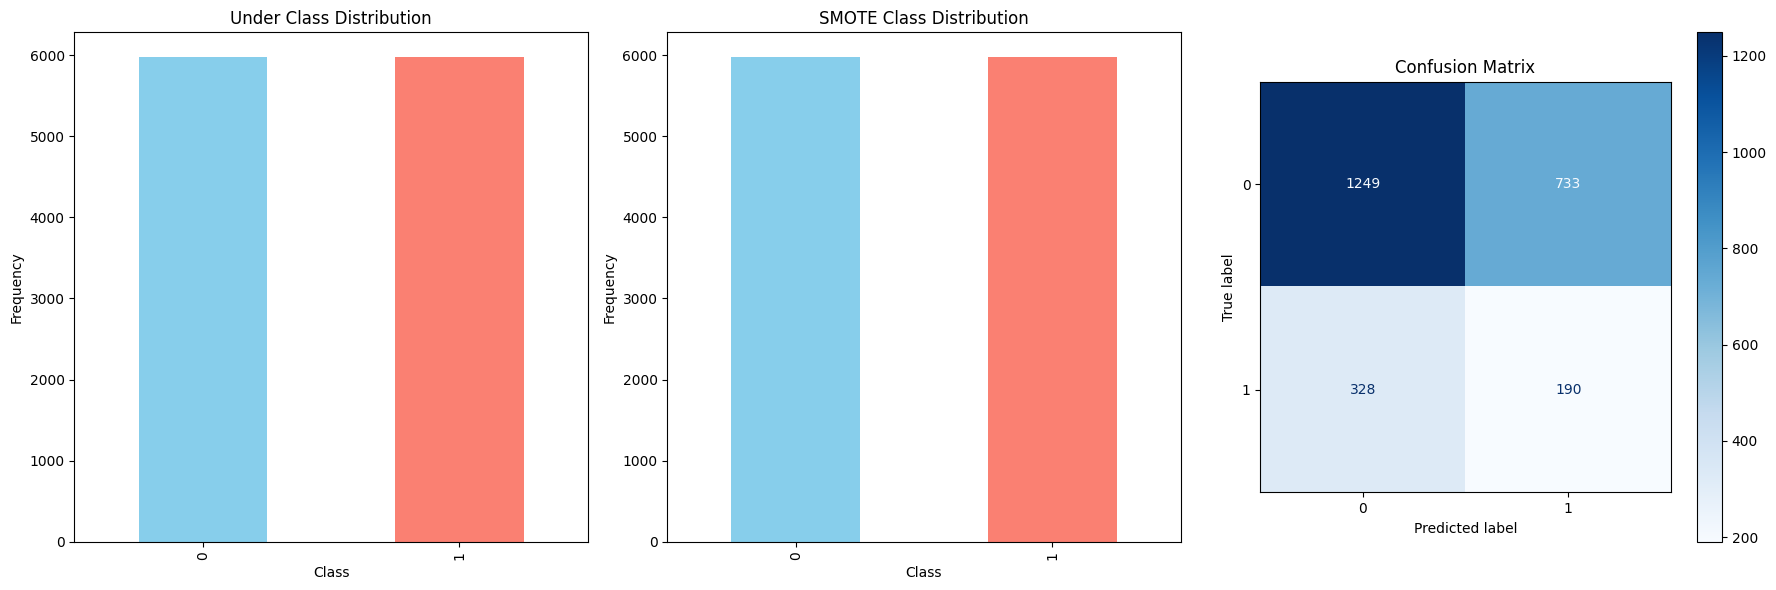

In [62]:
svm = SVC(gamma='scale')
svm.fit(X_ru, y_ru)

y_pred = svm.predict(X_test)



y_pred = svm.predict(X_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot oversampled class distribution
pd.Series(y_ro).value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title('Under Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')

# Plot SMOTE class distribution
pd.Series(y_sm).value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('SMOTE Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svm.classes_).plot(cmap=plt.cm.Blues, ax=axes[2])
axes[2].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [64]:
svm = SVC(probability=True, gamma='scale') # 'probability= True' is necessary to return the probabilitiess
svm.fit(X_ru, y_ru)                        # but it slows down the training

threshold = 0.5 # Test with 0.4, 0.6, ...

probs = svm.predict_proba(X_test)
pred_class = (probs[:,1]>=threshold).astype('int')

pd.crosstab(y_test, pred_class)

col_0,0,1
Exited,,
0,1067,915
1,281,237


In [65]:
svm = SVC(gamma='scale', class_weight='balanced')
svm.fit(X_train, y_train)                         

preds = svm.predict(X_test)

pd.crosstab(y_test, preds)

col_0,0,1
Exited,,
0,1183,799
1,317,201
